In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
!pip install xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

Data

In [2]:
energy = pd.read_csv('../Energy_Project/Resources/AEP_hourly.csv', index_col=[0], parse_dates=[0])

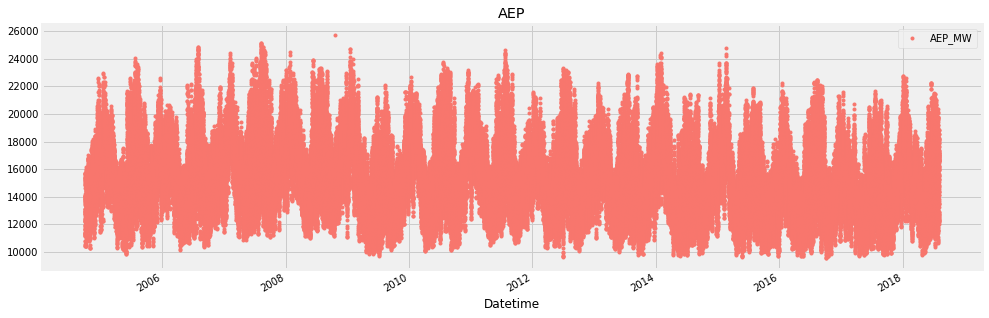

In [3]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = energy.plot(style='.', figsize=(15,5), color=color_pal[0], title='AEP')

Train/Test Split

In [4]:
split_date = '01-Oct-2014'
energy_train = energy.loc[energy.index <= split_date].copy()
energy_test = energy.loc[energy.index > split_date].copy()

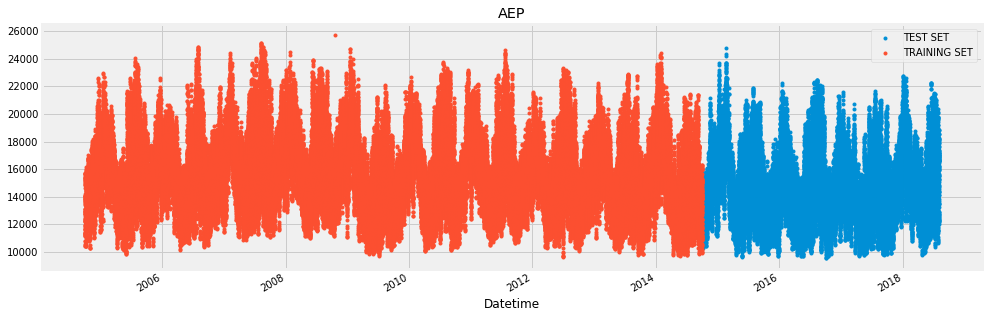

In [5]:
_ = energy_test \
    .rename(columns={'AEP_MW': 'TEST SET'}) \
    .join(energy_train.rename(columns={'AEP_MW': 'TRAINING SET'}), how='outer') \
    .plot(figsize=(15,5), title='AEP', style='.')

Create Time Series Features

In [6]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [7]:
X_train, y_train = create_features(energy_train, label='AEP_MW')
X_test, y_test = create_features(energy_test, label='AEP_MW')

Create XGBoost Model

In [8]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

Feature Importances
Feature importance is a great way to get a general idea about which features the model is relying on most to make the prediction. This is a metric that simply sums up how many times each feature is split on.

We can see that the day of year was most commonly used to split trees, while hour and year came in next. Quarter has low importance due to the fact that it could be created by different dayofyear splits.

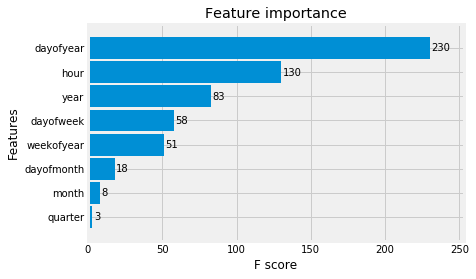

In [9]:
_ = plot_importance(reg, height=0.9)

Forecast on Test Set

In [10]:
energy_test['MW_Prediction'] = reg.predict(X_test)
energy_all = pd.concat([energy_test, energy_train], sort=False)

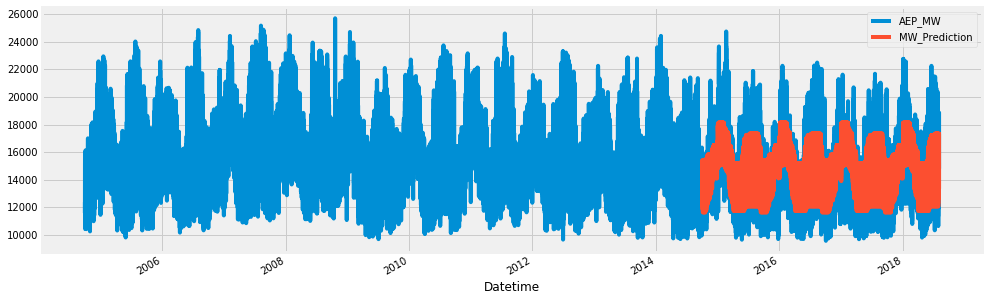

In [11]:
_ = energy_all[['AEP_MW','MW_Prediction']].plot(figsize=(15, 5))

Look at the First Month of Predictions

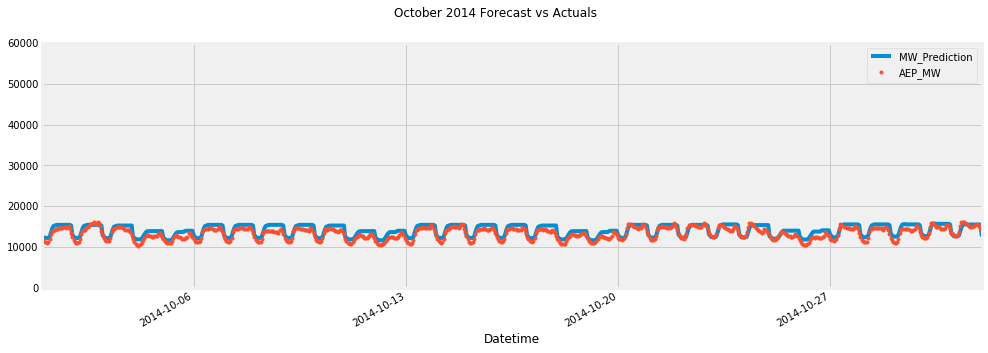

In [12]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = energy_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='10-01-2014', upper='11-01-2014')
ax.set_ylim(0, 60000)
plot = plt.suptitle('October 2014 Forecast vs Actuals')

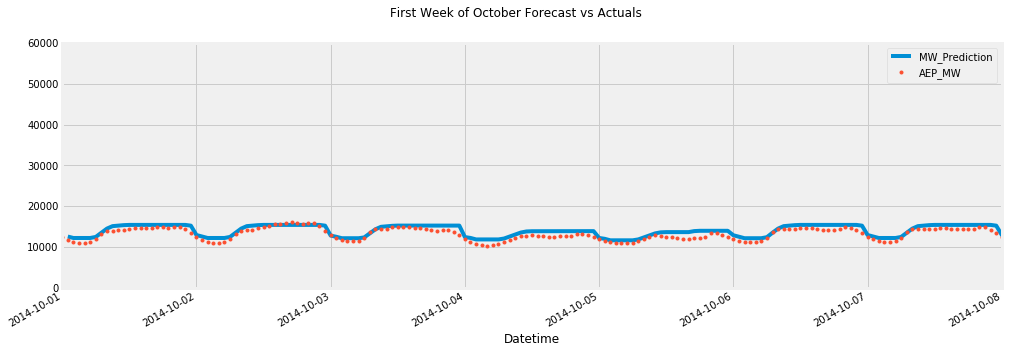

In [13]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = energy_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_xbound(lower='10-01-2014', upper='10-08-2014')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of October Forecast vs Actuals')

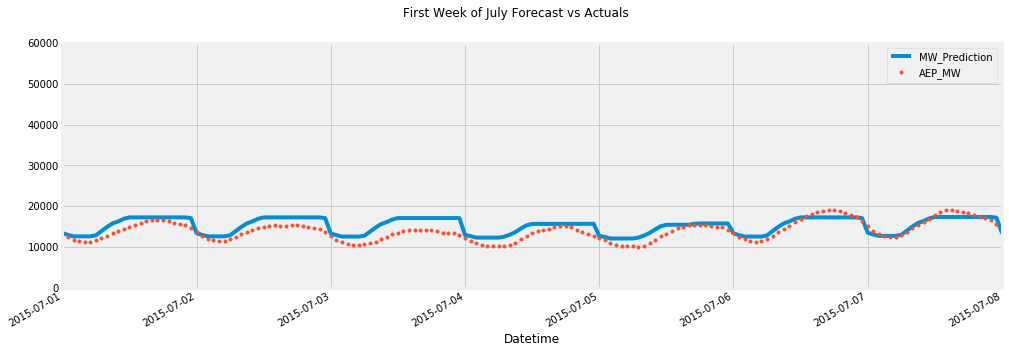

In [14]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = energy_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='07-01-2015', upper='07-08-2015')
plot = plt.suptitle('First Week of July Forecast vs Actuals')

Error Metrics on Test

Our RMSE error is 2636882/
Our MAE error is 1295.63/
Our MAPE error is 8.8%

In [15]:
mean_squared_error(y_true=energy_test['AEP_MW'],
                   y_pred=energy_test['MW_Prediction'])

2636882.2548517915

In [16]:
mean_absolute_error(y_true=energy_test['AEP_MW'],
                   y_pred=energy_test['MW_Prediction'])

1295.6268819028062

We are using mean absolute percent error because it gives an easy to interperate percentage showing how off the predictions are. MAPE isn't included in sklearn so we need to use a custom function.

In [17]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [18]:
mean_absolute_percentage_error(y_true=energy_test['AEP_MW'],
                   y_pred=energy_test['MW_Prediction'])

8.797890143799986

Look at Worst and best Predicted Days

In [19]:
energy_test['error'] = energy_test['AEP_MW'] - energy_test['MW_Prediction']
energy_test['abs_error'] = energy_test['error'].apply(np.abs)
error_by_day = energy_test.groupby(['year','month','dayofmonth']) \
    .mean()[['AEP_MW','MW_Prediction','error','abs_error']]

In [20]:
# Over forecasted days
error_by_day.sort_values('error', ascending=True).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 12    25          11078.041667   15754.386719 -4676.345296  4676.345296
           24          11466.041667   15886.607422 -4420.565877  4420.565877
2016 12    26          12242.375000   15870.253906 -3627.878418  3627.878418
2017 1     2           13478.583333   17102.794922 -3624.211711  3624.211711
2016 7     4           12048.000000   15560.648438 -3512.648153  3512.648153
2017 1     22          12295.541667   15765.777344 -3470.236043  3470.236043
     2     12          12408.791667   15765.777344 -3356.986043  3356.986043
           19          12189.541667   15526.181641 -3336.640340  3336.640340
2015 11    26          11718.500000   15005.337891 -3286.837728  3286.837728
2017 2     24          13111.625000   16383.228516 -3271.603841  3271.603841

Interesting Findings: The top dates are holidays; it would be cool to chart weather data against this to see if there was a cold front at the end of February

In [21]:
# Worst absolute predicted days
error_by_day.sort_values('abs_error', ascending=False).head(10)

AEP_MW  MW_Prediction        error    abs_error
year month dayofmonth                                                       
2015 2     19          22249.500000   16641.546875  5607.953776  5607.953776
           20          22047.041667   16539.716797  5507.325521  5507.325521
2018 1     6           20847.833333   16024.610352  4823.223307  4823.223307
2015 1     8           21873.333333   17119.148438  4754.184163  4754.184163
     12    25          11078.041667   15754.386719 -4676.345296  4676.345296
     2     16          21129.791667   16707.408203  4422.383260  4422.383260
     12    24          11466.041667   15886.607422 -4420.565877  4420.565877
     2     15          19695.958333   15526.181641  4169.776326  4169.776326
2014 11    18          19142.875000   15005.337891  4137.537272  4137.537272
2018 1     7           19803.375000   15690.599609  4112.775024  4112.775024

The best predicted days seem in October

In [22]:
# Best predicted days
error_by_day.sort_values('abs_error', ascending=True).head(10)

AEP_MW  MW_Prediction       error   abs_error
year month dayofmonth                                                     
2015 3     13          14841.541667   15014.239258 -172.697754  281.841960
2017 10    29          13135.416667   13222.018555  -86.601562  281.936198
2016 4     7           14262.041667   14309.604492  -47.562826  282.151449
2017 3     19          13611.000000   13639.269531  -28.269287  284.344320
2016 2     16          16887.500000   16723.761719  163.737467  294.018392
2017 2     3           17208.916667   17147.458984   61.458171  312.862549
2015 1     23          16982.875000   17147.458984 -164.583496  326.256510
     3     10          15276.750000   15116.069336  160.680664  328.709391
2014 10    22          14381.125000   14415.257812  -34.133219  329.099121
2017 11    16          14938.958333   14943.937500   -4.979655  337.485270

Plotting some best/worst predicted days

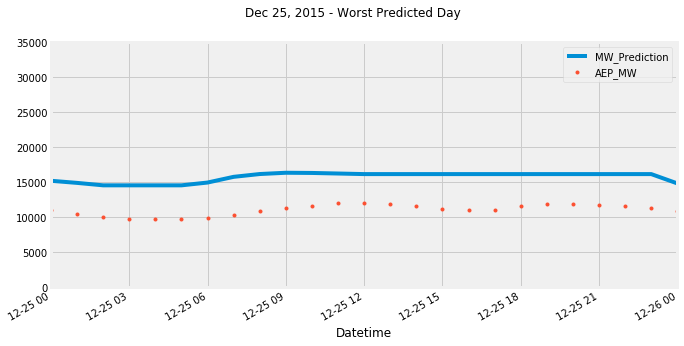

In [27]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = energy_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 35000)
ax.set_xbound(lower='12-25-2015', upper='12-26-2015')
plot = plt.suptitle('Dec 25, 2015 - Worst Predicted Day')

It was a high of 8 degrees in West Virginia on 02/19/2015, well below the average daily temperature of 34, and a low of 1 degree! In short, it was colder than normal which may have resulted in the model's undestimation.

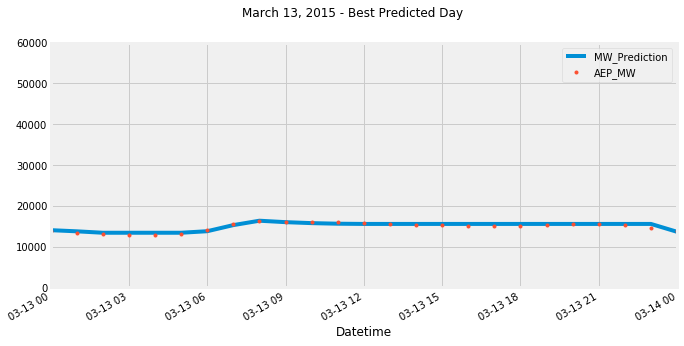

In [24]:
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = energy_all[['MW_Prediction','AEP_MW']].plot(ax=ax,
                                              style=['-','.'])
ax.set_ylim(0, 60000)
ax.set_xbound(lower='03-13-2015', upper='03-14-2015')
plot = plt.suptitle('March 13, 2015 - Best Predicted Day')

This one is nearly spot on!

Things to investigate: Weather Data, Holiday Indicators, Local Economic Activity Analysis